In [32]:
import sys

sys.path.append("../")

In [33]:
import requests
import time
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from arch import arch_model
from sklearn.model_selection import ParameterGrid
from multiprocessing import Pool
from datetime import datetime, timedelta

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
from statsmodels.tsa.stattools import adfuller as adf

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)
plt.ioff()

In [34]:
import warnings
warnings.filterwarnings('ignore')

In [35]:
API_BASE = 'https://fapi.binance.com/fapi/v1/'
DATA_PATH = '/mnt/c/Users/vmodg/source/repos/BeanRepos/crypto-pair-trading/data/'
# DATA_PATH = '/mnt/d/Working/PersonalProjects/Trading/trading-agent/crypto-pair-trading/data/crypto/'
# TIMEFRAME = '1d'
# lookback = 1000

TIMEFRAME = '1h'
lookback = 30*4

# TIMEFRAME = '15m'
# lookback = 30*2


In [36]:
API_BASE = 'https://fapi.binance.com/fapi/v1/'
TIMEFRAME = '1h'

LABELS = [
    'open_time',
    'open',
    'high',
    'low',
    'close',
    'volume',
    'close_time',
    'quote_asset_volume',
    'number_of_trades',
    'taker_buy_base_asset_volume',
    'taker_buy_quote_asset_volume',
    'ignore'
]

DROP_COLUMNS=[
    'close_time',
    'quote_asset_volume',
    'number_of_trades',
    'taker_buy_base_asset_volume',
    'taker_buy_quote_asset_volume',
    'ignore'
]


def get_batch(symbol, interval='1m', start_time=0, limit=1000):
    """Use a GET request to retrieve a batch of candlesticks. Process the JSON into a pandas
    dataframe and return it. If not successful, return an empty dataframe.
    """

    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': start_time,
        'limit': limit
    }
    try:
        # timeout should also be given as a parameter to the function
        response = requests.get(f'{API_BASE}klines', params, timeout=30)
    except requests.exceptions.ConnectionError:
        print('Connection error, Cooling down for 5 mins...')
        time.sleep(5 * 60)
        return get_batch(symbol, interval, start_time, limit)

    except requests.exceptions.Timeout:
        print('Timeout, Cooling down for 5 min...')
        time.sleep(5 * 60)
        return get_batch(symbol, interval, start_time, limit)

    if response.status_code == 200:
        return pd.DataFrame(response.json(), columns=LABELS)
    
    print(f'Got erroneous response back {symbol}: {response}. {response.text}')
    return pd.DataFrame([])


def get_candles(base, quote, start_date: datetime, interval='1m'):
    batches = []

    last_timestamp = int(start_date.timestamp()) * 1000
    # gather all candlesticks available, starting from the last timestamp loaded from disk or 0
    # stop if the timestamp that comes back from the api is the same as the last one
    previous_timestamp = None

    while previous_timestamp != last_timestamp:
        # stop if we reached data from today
        if datetime.fromtimestamp(last_timestamp / 1000) >= datetime.utcnow():
            break

        previous_timestamp = last_timestamp

        new_batch = get_batch(
            symbol=base + quote,
            interval=interval,
            start_time=last_timestamp
        )

        # requesting candles from the future returns empty
        # also stop in case response code was not 200
        if new_batch.empty:
            break

        last_timestamp = new_batch['open_time'].max()

        # sometimes no new trades took place yet on date.today();
        # in this case the batch is nothing new
        if previous_timestamp == last_timestamp:
            break

        batches.append(new_batch)
        last_datetime = datetime.fromtimestamp(last_timestamp / 1000)

        covering_spaces = 20 * ' '
        print(datetime.now(), base, quote, interval, str(last_datetime) + covering_spaces, end='\r', flush=True)

    if len(batches) > 0:
        # write clean version of csv to parquet
        df = pd.concat(batches, ignore_index=True)
        df.drop(columns=DROP_COLUMNS, inplace=True)
        df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
        df.set_index(keys=['open_time'], inplace=True)
        return df



In [37]:
def calculate_spread(df, symbols, hedge_ratio, nb_symbols = 2):
    spread = None
    for i in range(nb_symbols):
        if spread is None:
            spread = df[symbols[i]] * hedge_ratio[i]
        else:
            spread += df[symbols[i]] * hedge_ratio[i]
    
    spread.dropna(inplace=True)
    return spread

In [38]:
def get_data(symbols, timeframe):
    data = []

    for symbol in symbols:

        # print(p)
        df = get_candles(
            base=symbol,
            quote="USDT",
            start_date=datetime.utcnow() - timedelta(days=lookback),
            interval=timeframe,
        )
        if df is None:
            continue

        df.rename(columns={"close": symbol}, inplace=True)
        # the data is too long, just limit to recent period
        log = np.log(df[symbol].astype(np.float32))
        data.append(log)

    df = pd.concat(data, axis=1)
    df = df.dropna(axis=1, how="all")
    return df


In [39]:
symbols = ["ETC", "NEO"]
half_life = 66
timeframe = "1h"
hedge_ratio = [27.13571597, -15.50605355]

df = get_data(symbols, timeframe)
spread = calculate_spread(df, symbols, hedge_ratio)


In [40]:
log_returns = np.log(spread / spread.shift()) * 100
log_returns.dropna(inplace=True)
log_returns.tail()

open_time
2023-06-29 22:00:00   -0.082103
2023-06-29 23:00:00    0.428211
2023-06-30 00:00:00    1.284127
2023-06-30 01:00:00    0.616375
2023-06-30 02:00:00    0.204640
Name: ETC, dtype: float32

In [41]:

def fit_garch_model(params, returns):
    p = params['p']
    q = params['q']
    
    # Create the GARCH(p, q) model
    model = arch_model(returns, vol='Garch', p=p, q=q)

    # Fit the model
    result = model.fit(disp='off')

    # Get the AIC score
    aic = result.aic

    return (params, result, aic, p, q)

def find_best_garch_model(returns):
    # Define the range of parameters to search over
    p_values = list(range(1, 20))  # GARCH(p, q) p-values
    q_values = list(range(1, 20))  # GARCH(p, q) q-values

    # Create a parameter grid for the GARCH(p, q) model
    param_grid = ParameterGrid({'p': p_values, 'q': q_values})

    # Initialize variables to track the best model and its corresponding AIC
    best_model = None
    best_aic = float("inf")
    best_p = None
    best_q = None

    # Create a pool of workers for multiprocessing
    pool = Pool()

    # Fit GARCH models using multiprocessing
    results = pool.starmap(fit_garch_model, [(params, returns) for params in param_grid])

    # Close the pool of workers
    pool.close()
    pool.join()

    # Iterate over the results and find the best model
    for params, result, aic, p, q in results:
        if aic < best_aic:
            best_aic = aic
            best_model = result
            best_p = p
            best_q = q

    # Print the best model's summary and return the model object
    print('Params', best_p, best_q)
    print(best_model.summary())
    return best_model

# Call the function with your returns series data
best_garch_model = find_best_garch_model(log_returns)
# best_garch_model

Params 2 14
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    ETC   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -594.453
Distribution:                  Normal   AIC:                           1224.91
Method:            Maximum Likelihood   BIC:                           1332.34
                                        No. Observations:                 2888
Date:                Fri, Jun 30 2023   Df Residuals:                     2887
Time:                        09:32:50   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         9.5266e-03  5.397e-03      1.765

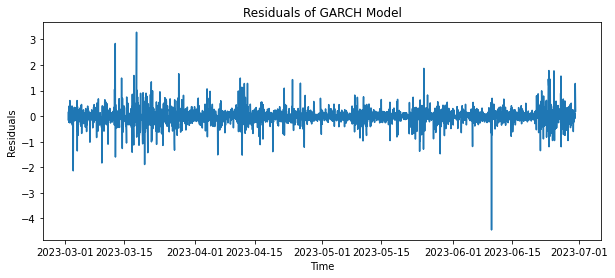

In [42]:
# Obtain model estimated residuals and volatility
gm_resid = best_garch_model.resid
gm_std = best_garch_model.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid /gm_std

# Plot the residuals over time
plt.figure(figsize=(10, 4))
plt.plot(gm_resid)
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residuals of GARCH Model')
plt.show()

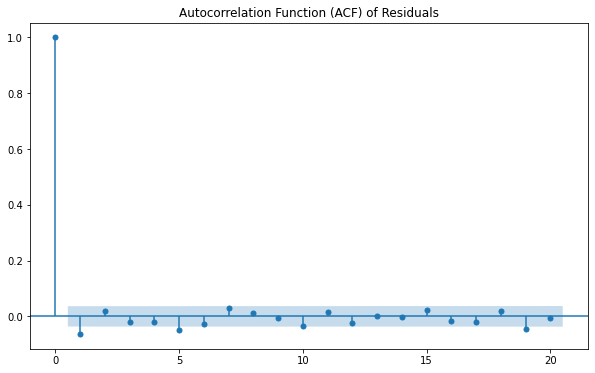

In [43]:
# Plot the autocorrelation function (ACF) of residuals
plot_acf(gm_resid, lags=20)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.show()

Ljung-Box test p-values: [0.00068064 0.00168047 0.00310059 0.00497589 0.00064588 0.00057158
 0.00044664 0.00081581 0.0015382  0.00079841 0.00110195 0.00105616
 0.00185268 0.00310485 0.00329875 0.00417327 0.0044708  0.00484705
 0.00119762 0.00186439]
Jarque-Bera test p-value: 0.0


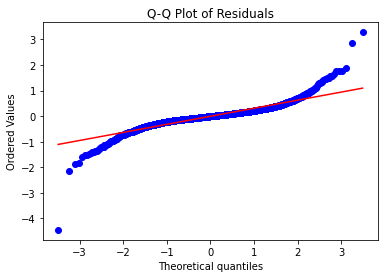

In [44]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera, probplot

# Obtain the residuals
residuals = best_garch_model.resid

# Ljung-Box test for residual autocorrelation
lb_stat, lb_p_value = acorr_ljungbox(residuals, lags=20)
print(f"Ljung-Box test p-values: {lb_p_value}")

# Jarque-Bera test for normality of residuals
jb_stat, jb_p_value = jarque_bera(residuals)
print(f"Jarque-Bera test p-value: {jb_p_value}")

# Q-Q plot of residuals
plt.figure(figsize=(6, 4))
probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

In [58]:
df = get_data(symbols, timeframe)
spread = calculate_spread(df, symbols, hedge_ratio)
log_returns = np.log(spread / spread.shift()) * 100
log_returns.dropna(inplace=True)

model = arch_model(log_returns, vol='Garch', p=2, q=14)
model_fit = model.fit()

Iteration:      1,   Func. Count:     20,   Neg. LLF: 57381.94114155914       
Iteration:      2,   Func. Count:     44,   Neg. LLF: 43880942.178538285
Iteration:      3,   Func. Count:     64,   Neg. LLF: 457324.1020536176
Iteration:      4,   Func. Count:     84,   Neg. LLF: 776.9641415867792
Iteration:      5,   Func. Count:    106,   Neg. LLF: 897.8612520994872
Iteration:      6,   Func. Count:    126,   Neg. LLF: 687.8344329008158
Iteration:      7,   Func. Count:    146,   Neg. LLF: 656.2157967573172
Iteration:      8,   Func. Count:    166,   Neg. LLF: 4858.577991365062
Iteration:      9,   Func. Count:    186,   Neg. LLF: 722.4990620210496
Iteration:     10,   Func. Count:    206,   Neg. LLF: 636.1135560893722
Iteration:     11,   Func. Count:    226,   Neg. LLF: 610.3430038676572
Iteration:     12,   Func. Count:    246,   Neg. LLF: 595.7691799969606
Iteration:     13,   Func. Count:    265,   Neg. LLF: 604.1293415113868
Iteration:     14,   Func. Count:    285,   Neg. LLF: 62

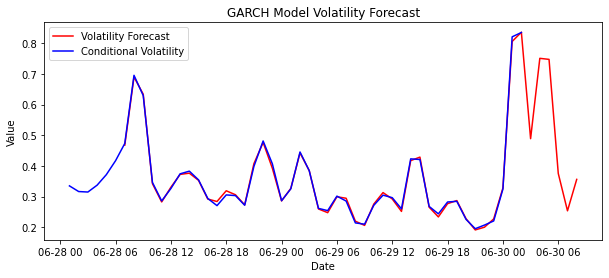

In [59]:
# Forecast volatility
forecast_horizon = 2  # Define the number of periods for volatility forecast
forecast = model_fit.forecast(horizon=forecast_horizon)
# np.sqrt(forecast.variance.values[-1, :])
# # Extract the forecasted volatility
volatility_forecast = np.sqrt(forecast.variance.values[-1, :])
# volatility_forecast

last_date = model_fit.conditional_volatility.index[-1]
forecast_index = pd.date_range(
    start=last_date + pd.DateOffset(hours=1), periods=forecast_horizon, freq="H"
)
forecast_index

# Append the forecasted volatility to the existing conditional_volatility series
combined_volatility = np.concatenate(
    [model_fit.conditional_volatility, volatility_forecast]
)
combined_index = pd.DatetimeIndex(
    np.concatenate([model_fit.conditional_volatility.index, forecast_index])
)

# Create a new DataFrame with the combined volatility and index
combined_df = pd.DataFrame(
    data=combined_volatility, index=combined_index, columns=["Volatility"]
)
combined_df = combined_df.tail(50)

# Plot the volatility forecast as an indicator
plt.figure(figsize=(10, 4))
plt.plot(combined_df.index, combined_df["Volatility"], color='red', label="Volatility Forecast")
plt.plot(
    best_garch_model.conditional_volatility.tail(50).index,
    best_garch_model.conditional_volatility.tail(50),
    color="blue",
    label="Conditional Volatility",
)
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("GARCH Model Volatility Forecast")
plt.legend()
plt.show()
